# Import libraries

In [9]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import pandas as pd
from scipy.optimize import curve_fit

# Exercise 3: Measurement of the total production cross sections

Load Data

In [10]:
meanenergy = np.array([88.47939, 89.46793, 90.22266, 91.22430, 91.96648, 92.96465, 93.71712])
lumi = np.array([463.9790, 667.5236, 486.7641, 2246.568, 535.9080, 450.6000, 709.6980])
stat = np.array([2.902361, 3.521166, 3.033955, 6.603405, 3.265110, 3.027953, 3.819882])
sys = np.array([3.104100, 4.471900, 3.261500, 15.04780, 3.585300, 3.020000, 4.762000])
all = np.array([4.249604, 5.691792, 4.454466, 16.43293, 4.849260, 4.276552, 6.104764])

In [11]:
### Open file

file_Opal = uproot.open('daten_4.root')
ttree_name_Opal = 'myTTree'

### Print list of 'branches' of the TTree (i.e. list of variable names)
print('Opal',file_Opal[ttree_name_Opal].keys())

## Load branches
branches_Opal = file_Opal[ttree_name_Opal].arrays()

var_Pcharged = 'Pcharged'
pchar_Opal = ak.to_numpy(branches_Opal[var_Pcharged])

var_Ncharged = 'Ncharged'
nchar_Opal = ak.to_numpy(branches_Opal[var_Ncharged])

var_E_ecal = 'E_ecal'
E_ecal_Opal = ak.to_numpy(branches_Opal[var_E_ecal])

var_E_hcal = 'E_hcal'
E_hcal_Opal = ak.to_numpy(branches_Opal[var_E_hcal])

var_cos_thet = 'cos_thet'
cos_thet_Opal = ak.to_numpy(branches_Opal[var_cos_thet])

var_E_lep = 'E_lep'
E_lep_Opal = ak.to_numpy(branches_Opal[var_E_lep]) 

print(f"Opal {E_lep_Opal} min: {E_lep_Opal.min()}, max: {E_lep_Opal.max()}")

data_Opal = pd.DataFrame({'COM_energy':np.zeros(len(nchar_Opal)), 'ID': np.chararray(len(nchar_Opal)),'Ncharged': nchar_Opal, 'Pcharged': pchar_Opal, 'E_ecal': E_ecal_Opal, 'E_hcal': E_hcal_Opal, 'E_lep':E_lep_Opal, 'cos_thet': cos_thet_Opal})

Opal ['run', 'event', 'Ncharged', 'Pcharged', 'E_ecal', 'E_hcal', 'E_lep', 'cos_thru', 'cos_thet']
Opal [45.627 45.627 45.627 ... 44.732 44.732 44.732] min: 44.23500061035156, max: 46.86199951171875


### separate the 7 different energies

In [12]:
def sevenEnergies(E_lep):
    Energies = np.array([])
    for i in range(len(E_lep)):
        if 2*E_lep[i]<(meanenergy[0]+meanenergy[1])/2:
            Energies = np.append(Energies,meanenergy[0])

        elif 2*E_lep[i]<(meanenergy[1]+meanenergy[2])/2:
            Energies = np.append(Energies,meanenergy[1])

        elif 2*E_lep[i]<(meanenergy[2]+meanenergy[3])/2:
            Energies = np.append(Energies,meanenergy[2])

        elif 2*E_lep[i]<(meanenergy[3]+meanenergy[4])/2:
            Energies = np.append(Energies,meanenergy[3])

        elif 2*E_lep[i]<(meanenergy[4]+meanenergy[5])/2:
            Energies = np.append(Energies,meanenergy[4])
        
        elif 2*E_lep[i]<(meanenergy[5]+meanenergy[6])/2:
            Energies = np.append(Energies,meanenergy[5])
        
        else:
            Energies = np.append(Energies,meanenergy[6])

    return Energies

In [13]:
data_Opal.loc[:, ['COM_energy']] = sevenEnergies(data_Opal['E_lep'])

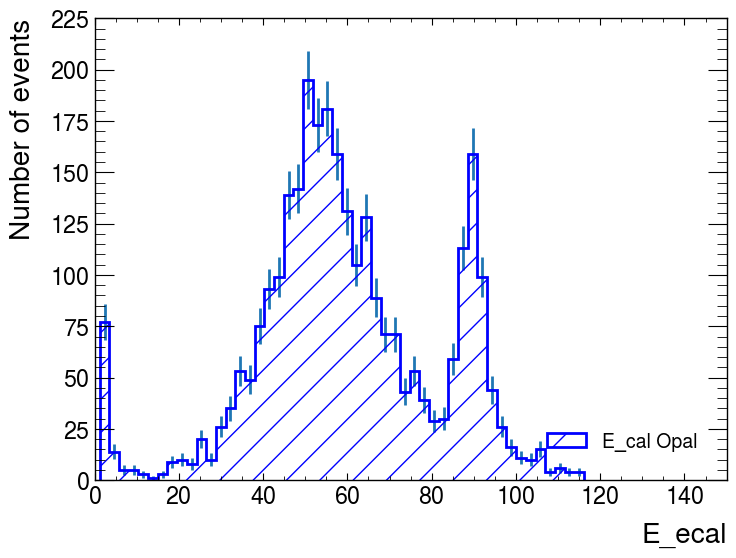

In [14]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
ratio = [1,4] # ratio of the two subplots

#Opal

bin_content_Opal, bin_edges_Opal, _ = plt.hist(data_Opal.loc[data_Opal['E_lep'] == 44.732]['E_ecal'],bins=50, histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='E_cal Opal')
mid_Opal = 0.5*(bin_edges_Opal[1:] + bin_edges_Opal[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content_Opal)

plt.errorbar(mid_Opal, bin_content_Opal, yerr=error_sizes, fmt='none')


#plt.ylim(0, 0.7*10**4)  # most of the data



### Show the plot on screen
plt.xlim(0,150)
plt.legend(loc = 4)
plt.xlabel('E_ecal')
plt.ylabel('Number of events')
plt.show()

First determine the number of events in the handronic channel *and* in the three leptonic channels


In [15]:
def classify_event_in_4CH(Ncharged, Pcharged, E_ecal, E_hcal, I):
    if len(Ncharged)==len(Pcharged)==len(E_ecal)==len(E_hcal):
        #print(Ncharged)
        PI = np.chararray((len(Ncharged),1), itemsize=2)[:]
        PI[:] = 'NC'      # create start PI array with all events unclassified
        NC = 0      
        ee = 0      
        qq = 0
        mm = 0
        tt = 0
        print(f'Classification for Energy {meanenergy[I]}:\n')                 
        for i in range(len(Ncharged)):
            
            if Ncharged[i] >= 7:
                PI[i] = "qq"
                qq += 1
            elif E_ecal[i] >= 60:
                PI[i] = "ee"
                ee += 1
            elif (70<=Pcharged[i] <= 110) & (E_ecal[i] < 20):
                PI[i] = "mm"
                mm += 1
            elif (Pcharged[i] < 10) & (E_ecal[i] < 10):
                PI[i] = "mm"
                mm += 1
            elif (E_ecal[i] < 100) & (1 < Pcharged[i] < 75):
                PI[i] = "tt"
                tt += 1
            else:
                PI[i] = "NC"
                NC += 1

        #print(PI)
        print('ee, mm, tt, qq, NC,len(Ncharged)')
        print(ee, mm, tt, qq, NC,len(Ncharged))
        print()
    else:
        print('Unequaly long input arrays')
    return [[ee, mm, tt, qq, NC, len(Ncharged)], PI]

### Add particle ID

In [55]:
nchar = data_Opal['Ncharged'].to_numpy()
pchar = data_Opal['Pcharged'].to_numpy()
E_ecal = data_Opal['E_ecal'].to_numpy()
E_hcal = data_Opal['E_hcal'].to_numpy()
data_Opal.loc[:, ['ID']] = classify_event_in_4CH(nchar, pchar, E_ecal, E_hcal, i)[1]
#len(classify_event_in_4CH(nchar, pchar, E_ecal, E_hcal, i)[1])

Classification for Energy 88.47939:

ee, mm, tt, qq, NC,len(Ncharged)
19643 4889 4740 111134 738 141144



### create callification Matrix sorted by energies

In [56]:
classify_Opal = np.zeros((7,6))
for i in range(0,7,1):
    print(i)
    nchar = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['Ncharged'].to_numpy()
    pchar = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['Pcharged'].to_numpy()
    E_ecal = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['E_ecal'].to_numpy()
    E_hcal = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['E_hcal'].to_numpy()
    classify_Opal[i] = classify_event_in_4CH(nchar, pchar, E_ecal, E_hcal, i)[0]
classify_Opal_error = np.sqrt(classify_Opal)

0
Classification for Energy 88.47939:

ee, mm, tt, qq, NC,len(Ncharged)
1557 94 116 2501 64 4332

1
Classification for Energy 89.46793:

ee, mm, tt, qq, NC,len(Ncharged)
2438 290 284 6653 82 9747

2
Classification for Energy 90.22266:

ee, mm, tt, qq, NC,len(Ncharged)
1876 402 399 8776 54 11507

3
Classification for Energy 91.2243:

ee, mm, tt, qq, NC,len(Ncharged)
8980 2955 2784 66937 353 82009

4
Classification for Energy 91.96648:

ee, mm, tt, qq, NC,len(Ncharged)
1829 579 555 13010 70 16043

5
Classification for Energy 92.96465:

ee, mm, tt, qq, NC,len(Ncharged)
1180 273 294 6264 54 8065

6
Classification for Energy 93.71712:

ee, mm, tt, qq, NC,len(Ncharged)
1783 296 308 6993 61 9441



In [106]:
classify_Opal_df = pd.DataFrame(dict(zip(['ee', 'mm', 'tt', 'qq', 'NC','length'], classify_Opal.transpose())))
classify_Opal_df['CMS_energies'] = meanenergy
classify_Opal_df = classify_Opal_df.join(pd.DataFrame(classify_Opal_error[:, :4], columns = ['ee_u', 'mm_u', 'tt_u', 'qq_u']))
classify_Opal_df

,ee,mm,tt,qq,NC,length,CMS_energies,ee_u,mm_u,tt_u,qq_u
0,1557.0,94.0,116.0,2501.0,64.0,4332.0,88.47939,39.458839,9.695360,10.770330,50.009999
1,2438.0,290.0,284.0,6653.0,82.0,9747.0,89.46793,49.376108,17.029386,16.852300,81.565924
2,1876.0,402.0,399.0,8776.0,54.0,11507.0,90.22266,43.312816,20.049938,19.974984,93.680307
3,8980.0,2955.0,2784.0,66937.0,353.0,82009.0,91.22430,94.762862,54.359912,52.763624,258.721858
4,1829.0,579.0,555.0,13010.0,70.0,16043.0,91.96648,42.766810,24.062419,23.558438,114.061387
5,1180.0,273.0,294.0,6264.0,54.0,8065.0,92.96465,34.351128,16.522712,17.146428,79.145436
6,1783.0,296.0,308.0,6993.0,61.0,9441.0,93.71712,42.225585,17.204651,17.549929,83.624159


(array([ 31.,  20.,  11.,  10.,  13.,   6.,  13.,  11.,  10.,   8.,  13.,
          6.,  11.,  10.,   4.,   3.,   6.,   7.,   6.,   9.,   6.,   8.,
          5.,   9.,   9.,   5.,   5.,   7.,  14.,   9.,   5.,   8.,  11.,
          5.,   7.,   8.,  10.,  16.,   9.,  12.,  18.,  20.,  26.,  23.,
         26.,  55.,  70., 112., 132.,  56.]),
 array([-0.9966405 , -0.9567181 , -0.9167957 , -0.87687325, -0.83695084,
        -0.7970284 , -0.75710595, -0.71718353, -0.6772611 , -0.6373387 ,
        -0.5974163 , -0.55749387, -0.51757145, -0.477649  , -0.4377266 ,
        -0.39780417, -0.35788175, -0.31795934, -0.2780369 , -0.23811448,
        -0.19819206, -0.15826964, -0.11834721, -0.0784248 , -0.03850237,
         0.00142005,  0.04134247,  0.0812649 ,  0.12118731,  0.16110975,
         0.20103216,  0.24095458,  0.280877  ,  0.32079944,  0.36072186,
         0.40064427,  0.4405667 ,  0.4804891 ,  0.52041155,  0.56033397,
         0.6002564 ,  0.6401788 ,  0.6801012 ,  0.72002363,  0.75994605,
 

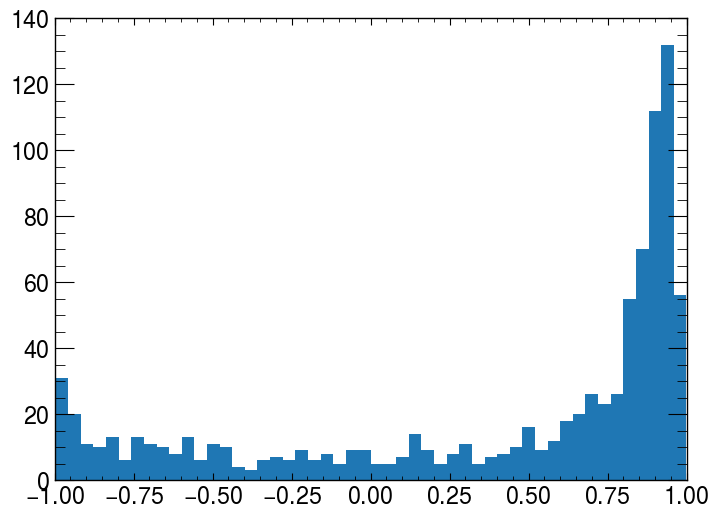

In [75]:
i = 2
plt.hist(data_Opal[(data_Opal['COM_energy'] == meanenergy[i]) & (data_Opal['ID'] == b'ee') & (data_Opal['cos_thet']<=1)]['cos_thet'].to_numpy(), bins = 50)

In [77]:
len(data_Opal[(data_Opal['ID'] == b'ee') & (data_Opal['cos_thet']>1)]['cos_thet'].to_numpy())

10214

In [78]:
len(data_Opal[(data_Opal['ID'] == b'ee')]['cos_thet'].to_numpy())

19643

### Correct background and efficiancy 

$N_{cut corr} = N_{cut} \epsilon^{-1}$

In [135]:
Matrix = np.array([[9.941e-01, 0.000e+00, 1.100e-03, 3.000e-04, 4.600e-03],
       [0.000e+00, 9.477e-01, 3.430e-02, 0.000e+00, 1.800e-02],
       [4.030e-02, 7.700e-03, 9.254e-01, 1.230e-02, 1.430e-02],
       [1.000e-03, 0.000e+00, 4.100e-03, 9.947e-01, 2.000e-04]])

Matrix_inv = np.linalg.inv(Matrix[:, :4])

Matrix_error_inv = np.array([[4.57926827e-03, 9.67518209e-07, 1.18074831e-04, 5.38185153e-05],
 [3.43399360e-05, 4.92972683e-03, 7.26840606e-04, 1.72674727e-04],
 [2.30087278e-04, 4.17500543e-05, 2.57312975e-04, 4.77883892e-03],
 [7.70717909e-04, 3.31387098e-04, 5.16922627e-03, 4.06636890e-04]])

In [183]:
Ncutcorr = np.zeros((7,4))
Ncutcorr_err = np.zeros((7,4))
for i in range(0,7,1):
    N_df = pd.DataFrame(classify_Opal_df.loc[classify_Opal_df['CMS_energies'] == meanenergy[i],['ee', 'mm', 'tt', 'qq']])
    Ncor = np.reshape(N_df.to_numpy(dtype=float),4).dot(Matrix_inv)
    Ncutcorr[i] = Ncor
    #Ncutcorr[i] = Ncor

In [184]:
Ncutcorr

array([[ 1559.30588397,    98.30414491,   108.7223204 ,  2512.51123323],
       [ 2435.0787125 ,   303.86616594,   263.12136908,  6684.46072539],
       [ 1863.09141941,   421.14391562,   374.27417719,  8817.5706245 ],
       [ 8860.83997216,  3097.07148538,  2585.11081867, 67259.01767864],
       [ 1805.73881946,   606.75071827,   517.18757041, 13072.38048782],
       [ 1169.40925464,   285.80846837,   277.8330551 ,  6293.58784623],
       [ 1774.83493925,   309.9943348 ,   288.09985876,  7026.16258295]])

In [162]:
help(pd.DataFrame.to_numpy)

Help on function to_numpy in module pandas.core.frame:

to_numpy(self, dtype: 'NpDtype | None' = None, copy: 'bool' = False, na_value=<no_default>) -> 'np.ndarray'
    Convert the DataFrame to a NumPy array.
    
    By default, the dtype of the returned array will be the common NumPy
    dtype of all types in the DataFrame. For example, if the dtypes are
    ``float16`` and ``float32``, the results dtype will be ``float32``.
    This may require copying data and coercing values, which may be
    expensive.
    
    Parameters
    ----------
    dtype : str or numpy.dtype, optional
        The dtype to pass to :meth:`numpy.asarray`.
    copy : bool, default False
        Whether to ensure that the returned value is not a view on
        another array. Note that ``copy=False`` does not *ensure* that
        ``to_numpy()`` is no-copy. Rather, ``copy=True`` ensure that
        a copy is made, even if not strictly necessary.
    na_value : Any, optional
        The value to use for missing